In [115]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy
from matplotlib import pyplot as plt

In [116]:
mnist_train_data=torchvision.datasets.MNIST('./',train=True, transform=torchvision.transforms.ToTensor(),download=True)

In [4]:
# Variational Auto Encoder 구현해보기
class Config(dict):
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__

In [114]:
config=Config({'batch_size':64,'hidden_dim':256,'latent_dim':20,'input_size':28*28,'device':torch.device('cuda' if torch.cuda.is_available() else 'cpu')})

In [117]:
train_data_loader=torch.utils.data.DataLoader(mnist_train_data,batch_size=config.batch_size,shuffle=True,drop_last=True)

In [125]:
class encoding(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.config=config
        self.fc=nn.Sequential(nn.Linear(self.config.input_size,self.config.hidden_dim),nn.ReLU())
        self.Mu=nn.Linear(self.config.hidden_dim,self.config.latent_dim)
        self.Log_var=nn.Linear(self.config.hidden_dim,self.config.latent_dim) # log var로 하는 것이, 범위 조건이 없으므로
        
    def forward(self,data):
        x=data.reshape(-1,self.config.input_size) # batch_size, input_size
        x=self.fc(x)
        mu=self.Mu(x)
        log_var=self.Log_var(x)
        return mu,log_var
    
class decoding(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.config=config
        self.fc1=nn.Sequential(nn.Linear(self.config.latent_dim,self.config.hidden_dim),nn.ReLU())
        self.fc2=nn.Sequential(nn.Linear(self.config.hidden_dim,self.config.input_size),nn.Sigmoid())
    def forward(self,z):
        x=self.fc1(z)
        output=self.fc2(x)
        return output

In [122]:
class variational_auto_encoder(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.config=config
        self.encoder=encoding(config)
        self.decoder=decoding(config)
        
    def reparametrization(self,mu,log_var):
        sigma=torch.exp(0.5*log_var).to(device)
        e=torch.randn_like(sigma).to(device)
        z=mu+sigma*e
        return z
        
    def forward(self,data):
        mu,log_var=self.encoder(data)
        z=self.reparametrization(mu,log_var)
        output=self.decoder(z)
        return output,mu,log_var

In [130]:
def train():
    avg_loss=0
    avg_loss1=0
    avg_loss2=0
    n=0
    
    for x,_ in train_data_loader:
        x=x.to(device)
        x_,mu,log_var=model(x)
        optimizer.zero_grad() # 븅신 이것의 위치였어...
        BCE=F.binary_cross_entropy(x_,x.reshape(config.batch_size,-1),size_average=False)#,) # reduction = sum으로 해주는 까닭은 이 항의 부분을 크게해서 이 부분에 좀 더 집중 되게
        # 최적화를 시키려고
        KL=-0.5*(log_var+1.-log_var.exp()-mu.pow(2)).sum()
        loss=BCE+KL
        avg_loss+=loss.item()
        avg_loss1+=BCE.item()
        avg_loss2+=KL.item()
        n+=1
        loss.backward()
        optimizer.step()
    if epoch%1==0:
        print(epoch)
        print(avg_loss/n,avg_loss1/n,avg_loss2/n)
        with torch.no_grad():
            batch=next(iter(train_data_loader))[0]
            batch=batch.to(device)
            predict,a,b=model(x)
            predict=predict.reshape(config.batch_size,28,28)
            plt.imshow(predict[0].cpu().detach().numpy())
            plt.show()
            plt.imshow(batch[0].cpu().detach().numpy().reshape(28,28))
            plt.show()
    cost.append(avg_loss/n)

In [14]:
def test(test_data):
    with torch.no_grad():
        y,mu,sigma=model.forward(test_data)
        z=mu+sigma*torch.randn(config.batch_size,config.hidden_dim).to(config.device)
        output=model.decoder(z)
        return output,mu,sigma

0
9935.12208698806 8849.236168143843 1085.8859155200971


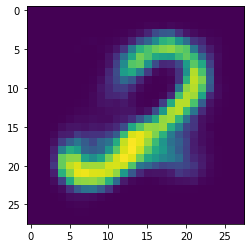

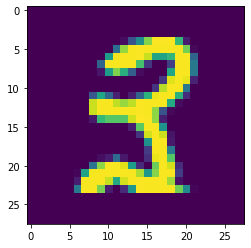

1
7660.258412299059 6225.533371965048 1434.7250383798444


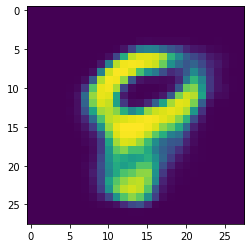

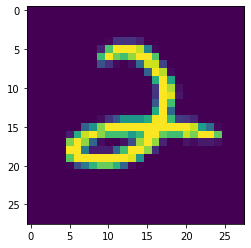

2
7301.691021669891 5798.125165713381 1503.565852569287


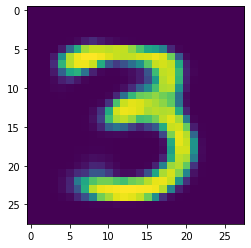

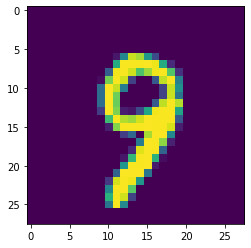

3
7134.685098719317 5597.205496577341 1537.4795986244746


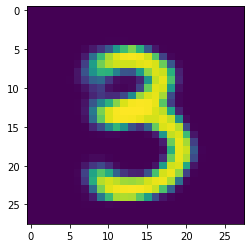

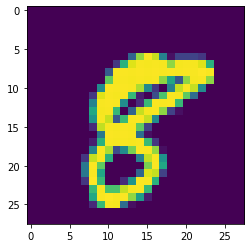

4
7034.183321729923 5473.411190134739 1560.7721347218517


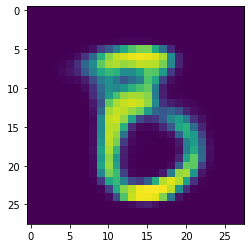

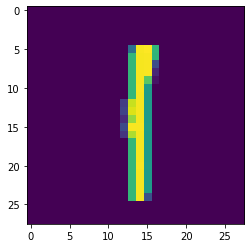

5
6969.03600461913 5393.140456159952 1575.8955420755653


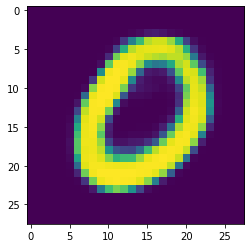

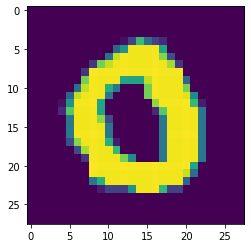

6
6917.051967820337 5334.870573159852 1582.1813957027082


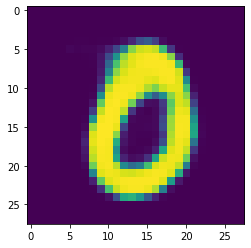

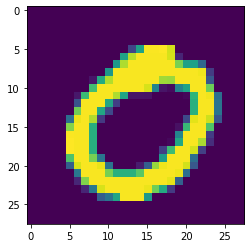

7
6882.512900630336 5294.134353425994 1588.3785477254535


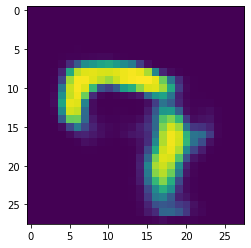

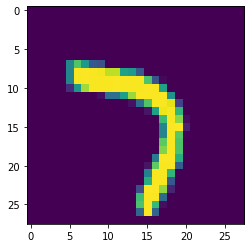

8
6855.767008550393 5262.065524008638 1593.7014844114778


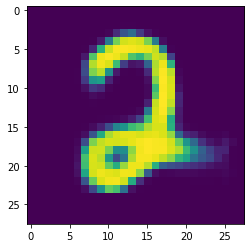

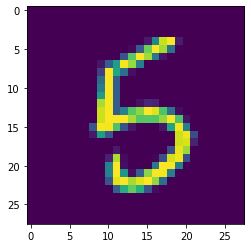

9
6832.095738039455 5233.823096797459 1598.2726512733875


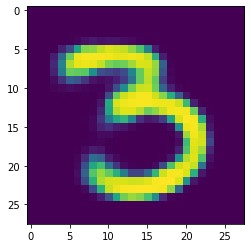

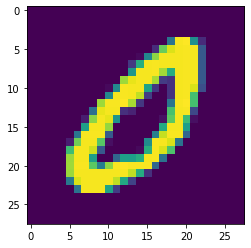

10
6812.970878739495 5211.018548955276 1601.952333431997


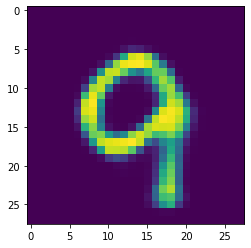

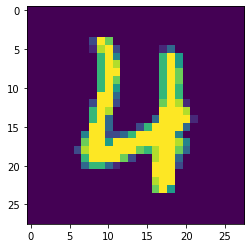

11
6794.801167393443 5193.886681229989 1600.9144958040122


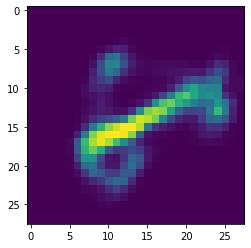

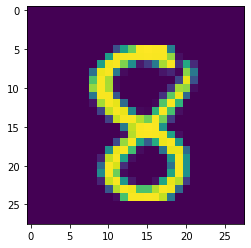

12
6781.143196684065 5176.170100095051 1604.9730991945705


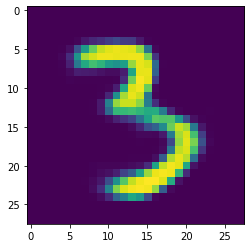

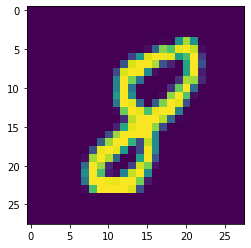

13
6764.463153786186 5161.708848886073 1602.7543056817804


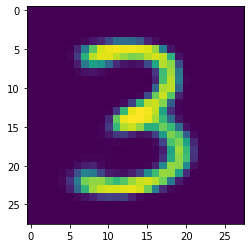

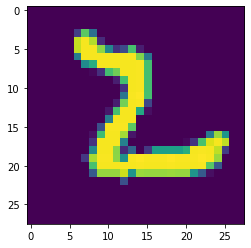

14
6753.101490586646 5147.521957544023 1605.5795334334562


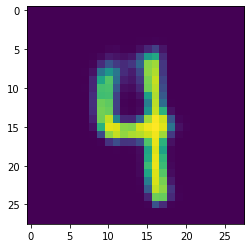

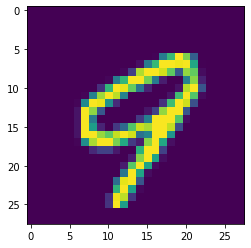

15
6742.669261105923 5136.012738043623 1606.6565282734125


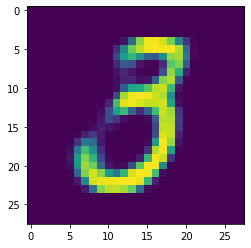

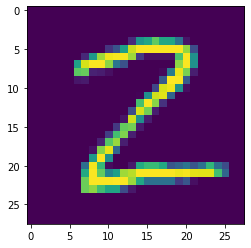

16
6734.527999307964 5126.588002142809 1607.9400004221002


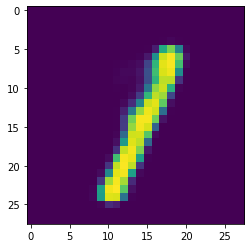

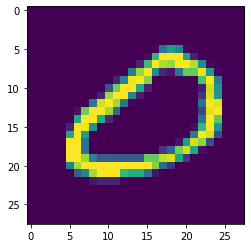

17
6725.941929445705 5117.050616578842 1608.8912999693587


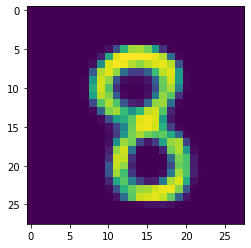

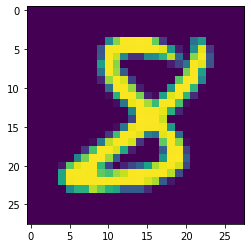

18
6715.657869092683 5106.688914295958 1608.968949846168


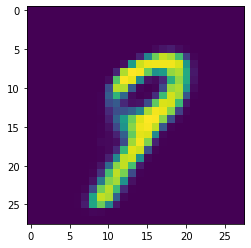

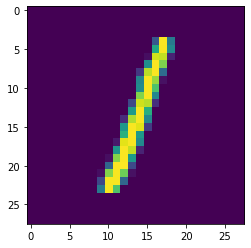

19
6706.422592049093 5098.798378405983 1607.624223283668


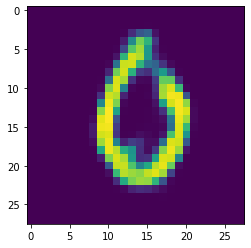

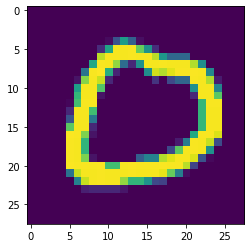

In [131]:
import time

# device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device='cpu'
epochs=20
model=variational_auto_encoder(config).to(device)
 
optimizer=torch.optim.Adam(model.parameters())
cost=[]
for epoch in range(epochs):
    now=time.time()
    train()
    

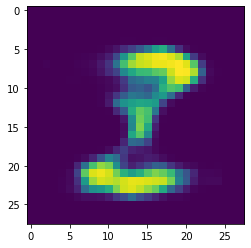

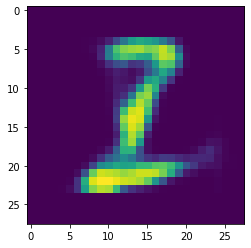

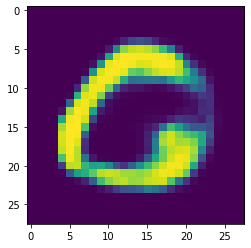

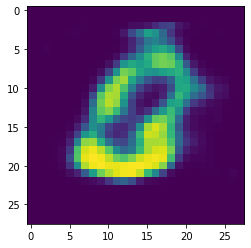

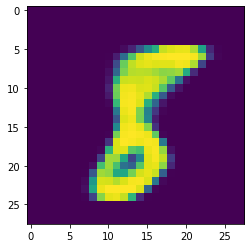

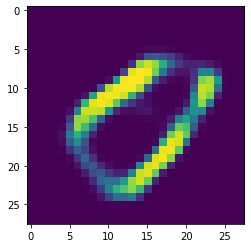

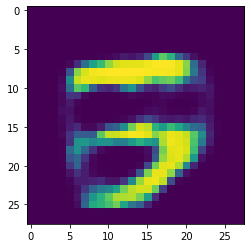

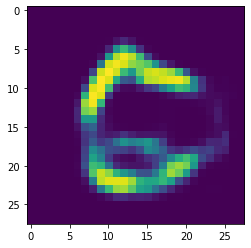

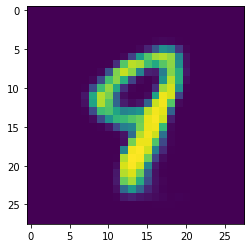

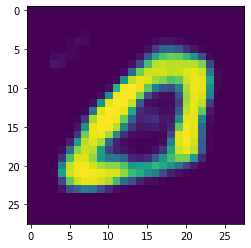

In [133]:
z=torch.randn(10,20)
for i in range(10):
    plt.imshow(model.decoder(z[i,:]).reshape(28,28).detach().numpy())
    plt.show()